## Creating a Simple MODFLOW 6 Model with Flopy

The purpose of this notebook is to demonstrate the Flopy capabilities for building a simple MODFLOW 6 model from scratch, running the model, and viewing the results.  This notebook will demonstrate the capabilities using a simple well example.  

![mf6](./images/mf6_flowchart.png)

### Setup the Notebook Environment

In [30]:
import os

In [31]:
import sys
from tempfile import TemporaryDirectory

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.24.3
matplotlib version: 3.7.2
flopy version: 3.4.1


In [32]:
# For this example, we will set up a temporary workspace.
# Model input files and output files will reside here.
temp_dir = TemporaryDirectory()
workspace = os.path.join(temp_dir.name, "mf6Well")

In [33]:
# Alternatively - create a folder to save the output files
workspace = os.path.join(".", "mf6Well")
try: 
    os.mkdir(workspace) 
    print("Directory '%s' created" %workspace) 
except OSError as error: 
    print(error)    

[WinError 183] Cannot create a file when that file already exists: '.\\mf6Well'


### Create the Flopy Model Objects

We are creating a square model with a specified head equal to `initial_head` along all boundaries. The head at the cells in first row in the top layer is fixed to `const_head`. First, set the name of the model and the parameters of the model: the number of layers `nlay`, the number of rows and columns `nrow` and `ncol`, lengths of the sides of the model `L`, aquifer thickness `H`, hydraulic conductivity `hk`

In [34]:
model_name = "well_00"
initial_head = 0. # meters
const_head = 0. # meters
nlay, nrow, ncol = 1, 15, 15 
L = 15000 # meters
hk = 1.0 # m/d

One big difference between MODFLOW 6 and previous MODFLOW versions is that MODFLOW 6 is based on the concept of a simulation.  A simulation consists of the following:

* Temporal discretization (TDIS)
* One or more models (GWF is the only model supported at present)
* Zero or more exchanges (instructions for how models are coupled)
* Solutions

For this simple lake example, the simulation consists of the temporal discretization (TDIS) package (TDIS), a groundwater flow (GWF) model, and an iterative model solution (IMS), which controls how the GWF model is solved.



![mf6_simulation](./images/mf6_flowchart_p1.png)

In [35]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=model_name, exe_name="./bin/mf6_linux", version="mf6", sim_ws=workspace
)


In [36]:
# Create the Flopy temporal discretization object
ntimesteps = 19
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", 
    time_units="DAYS", 
    nper=1, 
    perioddata=[(3650, ntimesteps, 1.5)],
)


In [37]:
# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.ModflowIms(
    sim, 
    pname="ims", 
    complexity="SIMPLE"
    )

Now that the overall simulation is set up, we can focus on building the groundwater flow model.  The groundwater flow model will be built by adding packages to it that describe the model characteristics.

!['mf6_gwf'](./images/mf6_flowchart_p2.png)

Define the discretization of the model. All layers are given equal thickness. The `bot` array is build from `H` and the `Nlay` values to indicate top and bottom of each layer, and `delrow` and `delcol` are computed from model size `L` and number of cells `N`. Once these are all computed, the Discretization file is built.

In [38]:
# Create the Flopy groundwater flow (gwf) model object
gwf_name = "gwf_well_00"
model_nam_file = "{}.nam".format(gwf_name)
gwf = flopy.mf6.ModflowGwf(
    sim, 
    modelname="gwf_well_00", 
    model_nam_file=model_nam_file
    )

In [39]:
# Create the discretization package
top, bot = 0, -100
delrow = delcol = 1000.
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    length_units='METERS',
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delrow,
    delc=delcol,
    top=top,
    botm=bot,
)

In [40]:
# Create the initial conditions package
start = initial_head
ic = flopy.mf6.ModflowGwfic(
    gwf, 
    pname="ic", 
    strt=start
    )

In [41]:
# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, 
    pname="npf", 
    icelltype=1, 
    k=hk, 
    save_flows=True
)

In [42]:
# Create the storage package
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    pname="sto",
    save_flows=True,
    iconvert=[0],
    ss=2.0e-6,
    sy=0.2,
    transient={0: True},
)

In [43]:
# Create the well package
tdis.nper
stress_period_data = {}
for p in range(tdis.nper.array):
    stress_period_data[p] = [0, 7, 7,-600.,'well_00']

wel = flopy.mf6.ModflowGwfwel(
    gwf,
    pname="wel",
    print_input=True,
    print_flows=True,
    #auxiliary=[("var1")],
    maxbound=len(stress_period_data),
    stress_period_data=stress_period_data,
    boundnames=True,
    save_flows=True,
)

ra_wel = wel.stress_period_data.get_data(key=0)

In [44]:
# Create the constant head package.
# List information is created a bit differently for
# MODFLOW 6 than for other MODFLOW versions.  The
# cellid (layer, row, column, for a regular grid)
# must be entered as a tuple as the first entry.
# Remember that these must be zero-based indices!
chd_rec = []
for col in range(0, ncol):
    chd_rec.append([0, 0, col, const_head])

chd = flopy.mf6.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(chd_rec),
    stress_period_data={0: chd_rec},
    save_flows=True,
)

In [45]:
# The chd package stored the constant heads in a structured
# array, also called a recarray.  We can get a pointer to the
# recarray for the first stress period (iper = 0) as follows.
iper = 0
ra = chd.stress_period_data.get_data(key=0)
ra

rec.array([((0, 0, 0), 0.), ((0, 0, 1), 0.), ((0, 0, 2), 0.),
           ((0, 0, 3), 0.), ((0, 0, 4), 0.), ((0, 0, 5), 0.),
           ((0, 0, 6), 0.), ((0, 0, 7), 0.), ((0, 0, 8), 0.),
           ((0, 0, 9), 0.), ((0, 0, 10), 0.), ((0, 0, 11), 0.),
           ((0, 0, 12), 0.), ((0, 0, 13), 0.), ((0, 0, 14), 0.)],
          dtype=[('cellid', 'O'), ('head', '<f8')])

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

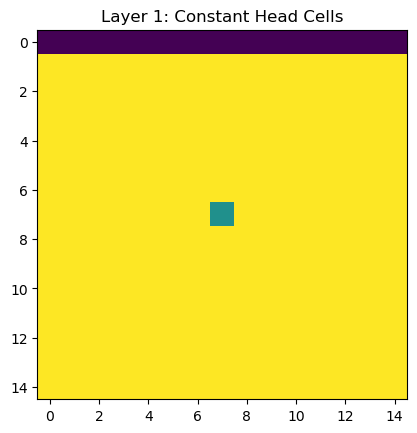

In [46]:
# We can make a quick plot to show where our constant
# heads are located by creating an integer array
# that starts with ones everywhere, but is assigned
# a -1 where chds are located
ibd = np.ones((nlay, nrow, ncol), dtype=int)
for k, i, j in ra["cellid"]:
    ibd[k, i, j] = -1

for k, i, j in ra_wel["cellid"]:
    ibd[k, i, j] = 0

plt.imshow(ibd[0, :, :], interpolation="none")
plt.title("Layer {}: Constant Head Cells".format(1))

In [47]:
# Create the output control package
headfile = "{}.hds".format(gwf_name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(gwf_name)
budget_filerecord = [budgetfile]
# Note mf6 no longer supports drawdown output 
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [48]:
# Note that help can always be found for a package
# using either forms of the following syntax
help(oc)
# help(flopy.mf6.modflow.mfgwfoc.ModflowGwfoc)

Help on ModflowGwfoc in module flopy.mf6.modflow.mfgwfoc object:

class ModflowGwfoc(flopy.mf6.mfpackage.MFPackage)
 |  ModflowGwfoc(model, loading_package=False, budget_filerecord=None, budgetcsv_filerecord=None, head_filerecord=None, headprintrecord=None, saverecord=None, printrecord=None, filename=None, pname=None, **kwargs)
 |  
 |  ModflowGwfoc defines a oc package within a gwf6 model.
 |  
 |  Parameters
 |  ----------
 |  model : MFModel
 |      Model that this package is a part of. Package is automatically
 |      added to model when it is initialized.
 |  loading_package : bool
 |      Do not set this parameter. It is intended for debugging and internal
 |      processing purposes only.
 |  budget_filerecord : [budgetfile]
 |      * budgetfile (string) name of the output file to write budget
 |        information.
 |  budgetcsv_filerecord : [budgetcsvfile]
 |      * budgetcsvfile (string) name of the comma-separated value (CSV) output
 |        file to write budget summary inf

### Create the MODFLOW 6 Input Files and Run the Model

Once all the flopy objects are created, it is very easy to create all of the input files and run the model.

In [49]:
# Write the datasets
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model gwf_well_00...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package wel...
    writing package chd...
    writing package oc...


In [50]:
# Print a list of the files that were created
# in workspace
print(os.listdir(workspace))

['gwf_well_00.cbb', 'gwf_well_00.chd', 'gwf_well_00.dis', 'gwf_well_00.dis.grb', 'gwf_well_00.hds', 'gwf_well_00.ic', 'gwf_well_00.lst', 'gwf_well_00.nam', 'gwf_well_00.npf', 'gwf_well_00.oc', 'gwf_well_00.sto', 'gwf_well_00.wel', 'mfsim.lst', 'mfsim.nam', 'well_00.ims', 'well_00.tdis']


### Run the Simulation

We can also run the simulation from the notebook, but only if the MODFLOW 6 executable is available.  The executable can be made available by putting the executable in a folder that is listed in the system path variable.  Another option is to just put a copy of the executable in the simulation folder, though this should generally be avoided.  A final option is to provide a full path to the executable when the simulation is constructed.  This would be done by specifying exe_name with the full path.

In [51]:
# Run the simulation
success, buff = sim.run_simulation(silent=True, report=True)
if success:
    for line in buff:
        print(line)
else:
    raise ValueError("Failed to run.")

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:41:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthoriz

### Post-Process Head Results

Post-processing MODFLOW 6 results is still a work in progress.  There aren't any Flopy plotting functions built in yet, like they are for other MODFLOW versions.  So we need to plot the results using general Flopy capabilities.  We can also use some of the Flopy ModelMap capabilities for MODFLOW 6, but in order to do so, we need to manually create a SpatialReference object, that is needed for the plotting.  Examples of both approaches are shown below.

First, a link to the heads file is created with `HeadFile`. The link can then be accessed with the `get_data` function, by specifying, in this case, the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions are used to make contours of the layers or a cross-section.

In [52]:
# Read the binary head file and plot the results
# We can use the existing Flopy HeadFile class because
# the format of the headfile for MODFLOW 6 is the same
# as for previous MODFLOW verions
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_alldata()

h.shape


(19, 1, 15, 15)

(0.0, 15.0, 0.0, 15.0)

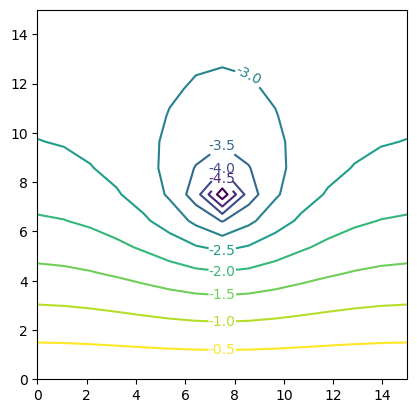

In [53]:

x = y = np.linspace(0, nrow, ncol)
min_hd = round(np.min(h[-1, 0,:, :]),0)
c = plt.contour(x, y, h[-1, 0,:, :], np.arange(min_hd, const_head, 0.5))
plt.clabel(c, fmt="%1.1f")
plt.axis("scaled")

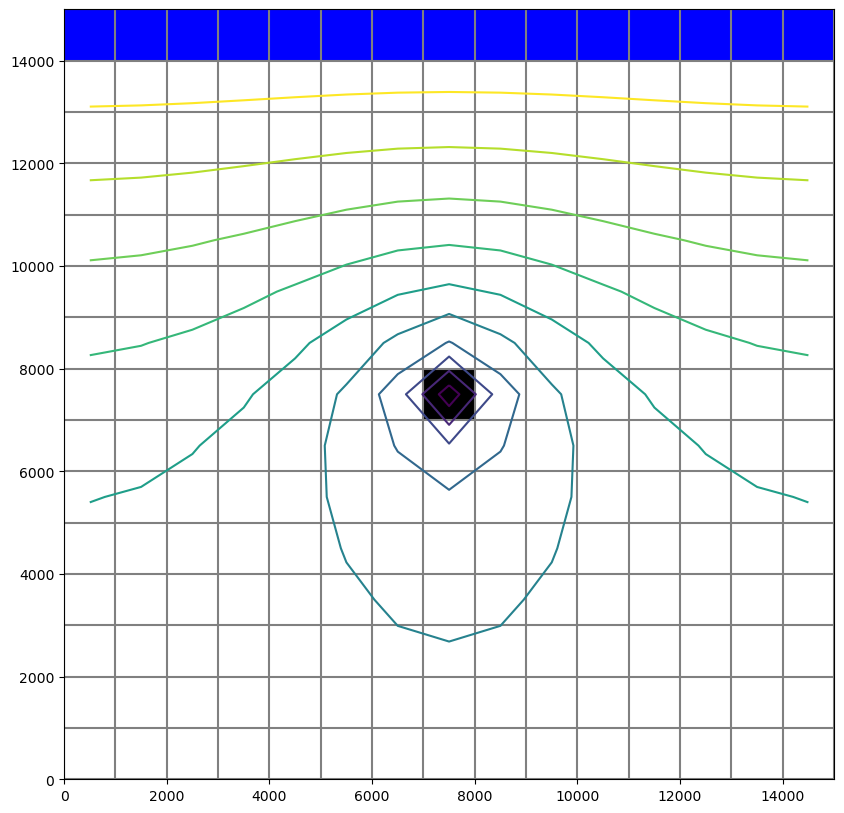

In [54]:
# We can also use the Flopy PlotMapView capabilities for MODFLOW 6
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
contours = modelmap.contour_array(h[-1,0], levels=np.arange(min_hd, const_head, 0.5))

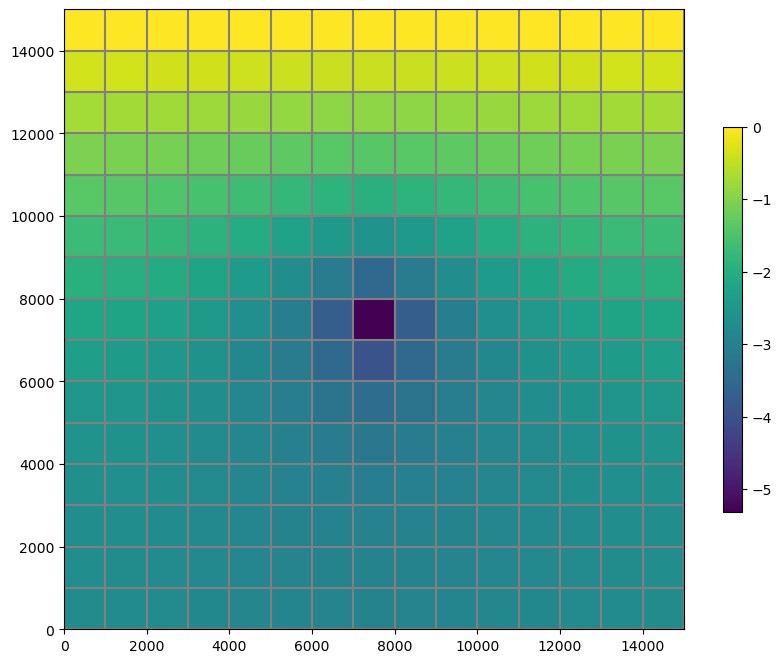

In [55]:
# We can also use the Flopy PlotMapView capabilities for MODFLOW 6
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
pa = modelmap.plot_array(h[-1, 0])
cb = plt.colorbar(pa, shrink=0.5)

### Post-Process Flows

MODFLOW 6 writes a binary grid file, which contains information about the model grid.  MODFLOW 6 also writes a binary budget file, which contains flow information.  Both of these files can be read using Flopy capabilities.  The MfGrdFile class in Flopy can be used to read the binary grid file.  The CellBudgetFile class in Flopy can be used to read the binary budget file written by MODFLOW 6.

In [56]:
# read the binary grid file
fname = os.path.join(workspace, "{}.dis.grb".format(gwf_name))
bgf = flopy.mf6.utils.MfGrdFile(fname)

# data read from the binary grid file is stored in a dictionary
bgf._datadict

{'NCELLS': 225,
 'NLAY': 1,
 'NROW': 15,
 'NCOL': 15,
 'NJA': 1065,
 'XORIGIN': 0.0,
 'YORIGIN': 0.0,
 'ANGROT': 0.0,
 'DELR': array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000.]),
 'DELC': array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000.]),
 'TOP': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [57]:
# read the cell budget file
fname = os.path.join(workspace, "{}.cbb".format(gwf_name))
cbb = flopy.utils.CellBudgetFile(fname, precision="double")
cbb.list_records()

flowja = cbb.get_data(text="FLOW-JA-FACE")[0][0, 0, :]
chdflow = cbb.get_data(text="CHD")[0]

(1, 1, b'          STO-SS', 15, 15, -1, 1, 0.82361623, 0.82361623, 0.82361623, b'', b'', b'', b'')
(1, 1, b'    FLOW-JA-FACE', 1065, 1, -1, 1, 0.82361623, 0.82361623, 0.82361623, b'', b'', b'', b'')
(1, 1, b'             WEL', 15, 15, -1, 6, 0.82361623, 0.82361623, 0.82361623, b'GWF_WELL_00     ', b'GWF_WELL_00     ', b'GWF_WELL_00     ', b'WEL             ')
(1, 1, b'             CHD', 15, 15, -1, 6, 0.82361623, 0.82361623, 0.82361623, b'GWF_WELL_00     ', b'GWF_WELL_00     ', b'GWF_WELL_00     ', b'CHD             ')
(2, 1, b'          STO-SS', 15, 15, -1, 1, 1.23542435, 2.05904058, 2.05904058, b'', b'', b'', b'')
(2, 1, b'    FLOW-JA-FACE', 1065, 1, -1, 1, 1.23542435, 2.05904058, 2.05904058, b'', b'', b'', b'')
(2, 1, b'             WEL', 15, 15, -1, 6, 1.23542435, 2.05904058, 2.05904058, b'GWF_WELL_00     ', b'GWF_WELL_00     ', b'GWF_WELL_00     ', b'WEL             ')
(2, 1, b'             CHD', 15, 15, -1, 6, 1.23542435, 2.05904058, 2.05904058, b'GWF_WELL_00     ', b'GWF_WELL_00

In [58]:
# By having the ia and ja arrays and the flow-ja-face we can look at
# the flows for any cell and process them in the follow manner.
k = 0
i = 7
j = 7
celln = k * nrow * ncol + i * nrow + j
ia, ja = bgf.ia, bgf.ja

print("Printing flows for cell {}".format(celln))
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]
    print("Cell {} flow with cell {} is {}".format(celln, cellm, flowja[ipos]))


Printing flows for cell 112
Cell 112 flow with cell 97 is 86.00576735858816
Cell 112 flow with cell 111 is 86.00576717103566
Cell 112 flow with cell 113 is 86.00576719283438
Cell 112 flow with cell 127 is 86.00576715501273
